In [1]:
!nvidia-smi

Sun May 12 03:35:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   27C    P8             16W /  230W |     549MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import math
from tqdm.auto import tqdm
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

In [3]:
def get_noise_schedules(beta1, beta2, T):
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    b = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_b = torch.sqrt(b)
    a = 1 - b
    log_a = torch.log(a)
    a_bar = torch.cumsum(log_a, dim=0).exp()

    sqrt_a_bar = torch.sqrt(a_bar)
    one_over_sqrt_a = 1 / torch.sqrt(a)

    sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar)
    one_minus_a_over_sqrt_abar = (1 - a) / sqrt_one_minus_a_bar

    return {
        "a": a,  # \alpha_t
        "one_over_sqrt_a": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_b": sqrt_b,  # \sqrt{\beta_t}
        "a_bar": a_bar,  # \bar{\alpha_t}
        "sqrt_a_bar": sqrt_a_bar,  # \sqrt{\bar{\alpha_t}}
        "sqrt_one_minus_a_bar": sqrt_one_minus_a_bar,  # \sqrt{1-\bar{\alpha_t}}
        "one_minus_a_over_sqrt_abar": one_minus_a_over_sqrt_abar,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

class NoiseScheduler(nn.Module):
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        beta = torch.linspace(self.beta_start, self.beta_end, self.num_timesteps + 1).to(device)
        sqrt_beta = torch.sqrt(beta)
        alpha = 1. - beta
        alpha_hat = torch.cumprod(alpha, dim=0)
        
        one_over_sqrt_alpha = 1 / torch.sqrt(alpha)
        sqrt_alpha_hat = torch.sqrt(alpha_hat)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat)

        self.register_buffer("beta", beta)
        self.register_buffer("sqrt_beta", sqrt_beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_hat", alpha_hat)
        self.register_buffer("one_over_sqrt_alpha", one_over_sqrt_alpha)
        self.register_buffer("sqrt_alpha_hat", sqrt_alpha_hat)
        self.register_buffer("sqrt_one_minus_alpha_hat", sqrt_one_minus_alpha_hat)

    def noise_images(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,))

    def denoise(self, noisy_image, predicted_noise, z, t):
        one_over_sqrt_alpha = self.one_over_sqrt_alpha[t]
        pred_noise_coeff = (1 - self.alpha[t])/self.sqrt_one_minus_alpha_hat[t]
        sqrt_beta = self.sqrt_beta[t]
        return (
                one_over_sqrt_alpha * (noisy_image - (pred_noise_coeff * predicted_noise))
                + sqrt_beta * z
            )

In [4]:
class UNetBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU()
        )

    def forward(self, x, skip=None):
        if skip is None:
            return self.conv(x)
        else:
            x = torch.cat((x, skip), 1)
            return self.conv(x)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class UNet(nn.Module):

    def __init__(self, num_channels):
        super().__init__()
        self.init_conv = UNetBlock(num_channels, 64)
        self.down_conv1 =  UNetBlock(64, 64)
        self.down_conv2 = UNetBlock(64, 128)
        self.down_conv3 = UNetBlock(128, 128)

        self.up_conv1 = UNetBlock(256, 128)
        self.up_conv2 = UNetBlock(256, 64)
        self.up_conv3 = UNetBlock(128, 64)
        self.out_conv = nn.Conv2d(128, num_channels, 3, 1, 1)

        self.mid_conv = nn.Sequential(
            nn.AvgPool2d(4), 
            nn.ReLU()
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, 4),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
        )

        self.time_embedding = SinusoidalPositionEmbeddings(128)
        self.time_embedding_mapper = nn.Linear(128, 64)

    def forward(self, x, t) -> torch.Tensor:
        time_emb = self.time_embedding(t)
        x = self.init_conv(x)

        down1_out = self.down_conv1(x)
        down2_out = self.down_conv2(down1_out)
        down3_out = self.down_conv3(down2_out)
        
        mid_out = self.mid_conv(down3_out)
        upsample_out = self.upsample(mid_out + time_emb[:,:,None,None])
        up1_out = self.up_conv1(upsample_out, down3_out) + time_emb[:,:,None,None]
        up2_out = self.up_conv2(up1_out, down2_out) + self.time_embedding_mapper(time_emb)[:,:,None,None]
        up3_out = self.up_conv3(up2_out, down1_out) + self.time_embedding_mapper(time_emb)[:,:,None,None]

        out = self.out_conv(torch.cat((up3_out, x), 1))

        return out

In [5]:
class Diffuser(nn.Module):
    def __init__(
        self,
        unet,
        noise_scheduler,
        num_timesteps,
        eta=0.
    ):
        super().__init__()
        self.unet = unet
        self.num_timesteps = num_timesteps
        self.criterion = nn.MSELoss()
        self.eta = eta
        self.noise_scheduler = noise_scheduler
        
    
    def forward(self, x):
        timesteps = torch.randint(1, self.num_timesteps, (x.shape[0],)).to(x.device)
        noisy_x, noise = self.noise_scheduler.noise_images(x, timesteps)
        predicted_noise = self.unet(noisy_x, timesteps/self.num_timesteps)
        return self.criterion(noise, predicted_noise)

   
    def sample(self, n_samples, size, device):
        x = torch.randn(n_samples, *size).to(device)
        
        for t in tqdm(range(self.num_timesteps, 0, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
            predicted_noise = self.unet(x, t / self.num_timesteps)
            x = self.noise_scheduler.denoise(x, predicted_noise, z, t-1)
        return x

    def sample_ddim(self, n_samples, size, device) -> torch.Tensor:
        x = torch.randn(n_samples, *size).to(device)

        for t in tqdm(range(self.num_timesteps, 1, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
            predicted_noise = self.unet(x, torch.tensor(t / self.num_timesteps).to(device).repeat(n_samples, ))
            x0_t = (x - predicted_noise * (1 - self.noise_scheduler.alpha_hat[t]).sqrt()) / self.noise_scheduler.alpha_hat[t].sqrt()
            c1 = self.eta * ((1 - self.noise_scheduler.alpha_hat[t] / self.noise_scheduler.alpha_hat[t - 1]) * (1 - self.noise_scheduler.alpha_hat[t - 1]) / (
                    1 - self.noise_scheduler.alpha_hat[t])).sqrt()
            c2 = ((1 - self.noise_scheduler.alpha_hat[t - 1]) - c1 ** 2).sqrt()
            x = self.noise_scheduler.alpha_hat[t - 1].sqrt() * x0_t + c1 * z + c2 * predicted_noise

        return x

In [6]:

dataset = load_dataset("../../ddpm/ddpm-data/summer2winter_yosemite/train", split="train[:500]")

img_size = 64
preprocess = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

Resolving data files:   0%|          | 0/2193 [00:00<?, ?it/s]

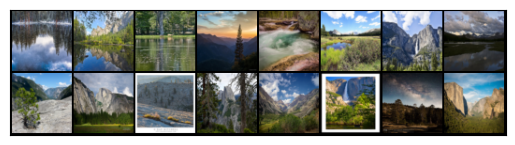

In [7]:
plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

batch = next(iter(train_dataloader))
show(make_grid(batch["images"][:16], normalize=True, value_range=(-1, 1)))

In [8]:
def get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

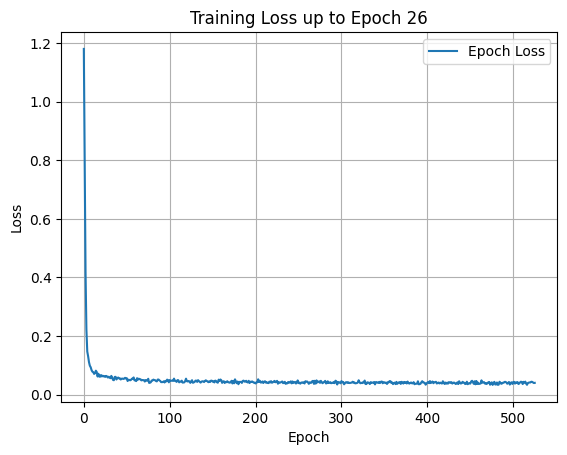

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
device = "cuda"
num_epochs = 500
save_every = 20
num_channels = 3
num_timesteps = 500
unet = UNet(num_channels).to(device)
scheduler = NoiseScheduler(num_timesteps)
ddpm_model = Diffuser(
    unet,
    scheduler,
    num_timesteps=num_timesteps,
    eta=0.5,
)
ddpm_model.to(device)

optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=1e-3)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

# Create a list to store the average loss of each epoch
epoch_losses = []

fig, ax = plt.subplots()
display_handle = display(fig, display_id=True)

with tqdm(range(num_epochs), desc="Epoch") as ep:
    for epoch in ep:
        ddpm_model.train()  # Setting the model to training mode
    
        pbar = tqdm(train_dataloader, desc="Training loop", leave=False)
        batch_losses = []  # List to store the loss of each batch
        for batch in pbar:
            optimizer.zero_grad()  # Zeroing the gradients
            lr = lr_scheduler.get_last_lr()
            x = batch["images"].to(device)
            # x = batch.to(device)
            loss = ddpm_model(x)  # Forward pass to compute the loss
            loss.backward()  # Backward pass to compute gradients
            nn.utils.clip_grad_norm_(ddpm_model.parameters(), 1.0)
            optimizer.step()  # Update model parameters
            lr_scheduler.step()
            # Store the loss of each batch
            batch_losses.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    
        # Calculate and store the average loss of the epoch
        epoch_avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_avg_loss)
        ep.set_postfix(avg_loss=epoch_avg_loss, lr=lr)
        
        # Clear the previous plot and plot the updated epoch_losses
        ax.clear()
        ax.plot(epoch_losses, label="Epoch Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Training Loss up to Epoch {epoch + 1}")
        ax.grid(True)
    
        # Redraw the plot
        display_handle.update(fig)

        if epoch % save_every == 0:
            ddpm_model.eval()
            with torch.no_grad():
                if epoch % 1 == 0:
                    samples = ddpm_model.sample_ddim(8, (3, img_size, img_size), device)
                    sample_set = torch.cat([samples, x[:8]], dim=0)
                    grid = make_grid(
                        sample_set, normalize=True, value_range=(-1, 1), nrow=4
                    )
                    save_image(grid, f"./samples/ddim_sample_{epoch}.png")
    
                torch.save(ddpm_model.state_dict(), "./models/ddpm_latest.pth")
    
    plt.close()

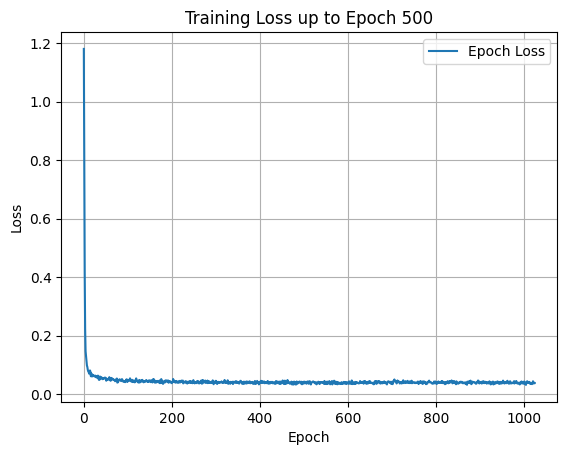

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

Training loop:   0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
fig, ax = plt.subplots()
display_handle = display(fig, display_id=True)

with tqdm(range(num_epochs), desc="Epoch") as ep:
    for epoch in ep:
        ddpm_model.train()  # Setting the model to training mode
    
        pbar = tqdm(train_dataloader, desc="Training loop", leave=False)
        batch_losses = []  # List to store the loss of each batch
        for batch in pbar:
            optimizer.zero_grad()  # Zeroing the gradients
            lr = lr_scheduler.get_last_lr()
            x = batch["images"].to(device)
            # x = batch.to(device)
            loss = ddpm_model(x)  # Forward pass to compute the loss
            loss.backward()  # Backward pass to compute gradients
            nn.utils.clip_grad_norm_(ddpm_model.parameters(), 1.0)
            optimizer.step()  # Update model parameters
            lr_scheduler.step()
            # Store the loss of each batch
            batch_losses.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    
        # Calculate and store the average loss of the epoch
        epoch_avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_avg_loss)
        ep.set_postfix(avg_loss=epoch_avg_loss, lr=lr)
        
        # Clear the previous plot and plot the updated epoch_losses
        ax.clear()
        ax.plot(epoch_losses, label="Epoch Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Training Loss up to Epoch {epoch + 1}")
        ax.grid(True)
    
        # Redraw the plot
        display_handle.update(fig)

        if epoch % save_every == 0:
            ddpm_model.eval()
            with torch.no_grad():
                if epoch % 1 == 0:
                    samples = ddpm_model.sample_ddim(8, (3, img_size, img_size), device)
                    sample_set = torch.cat([samples, x[:8]], dim=0)
                    grid = make_grid(
                        sample_set, normalize=True, value_range=(-1, 1), nrow=4
                    )
                    save_image(grid, f"./samples/ddim_sample_{epoch}.png")
    
                torch.save(ddpm_model.state_dict(), "./models/ddpm_latest.pth")
    
    plt.close()